In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

2023-11-08 21:14:52.357081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
#Read the csv file
df = pd.read_csv('SPY.csv')
print(df.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2012-01-03  127.760002  128.380005  127.430000  127.500000  102.458992   
1  2012-01-04  127.199997  127.809998  126.709999  127.699997  102.619682   
2  2012-01-05  127.010002  128.229996  126.430000  128.039993  102.892876   
3  2012-01-06  128.199997  128.220001  127.290001  127.709999  102.627716   
4  2012-01-09  128.000000  128.179993  127.410004  128.020004  102.876831   

      Volume  
0  193697900  
1  127186500  
2  173895000  
3  148050000  
4   99530200  


In [6]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

2961   2023-10-10
2962   2023-10-11
2963   2023-10-12
2964   2023-10-13
2965   2023-10-16
2966   2023-10-17
2967   2023-10-18
2968   2023-10-19
2969   2023-10-20
2970   2023-10-23
2971   2023-10-24
2972   2023-10-25
2973   2023-10-26
2974   2023-10-27
2975   2023-10-30
Name: Date, dtype: datetime64[ns]


In [7]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [8]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
print(df_for_training)

            Open        High         Low       Close   Adj Close
0     127.760002  128.380005  127.430000  127.500000  102.458992
1     127.199997  127.809998  126.709999  127.699997  102.619682
2     127.010002  128.229996  126.430000  128.039993  102.892876
3     128.199997  128.220001  127.290001  127.709999  102.627716
4     128.000000  128.179993  127.410004  128.020004  102.876831
...          ...         ...         ...         ...         ...
2971  422.649994  424.820007  420.739990  423.630005  423.630005
2972  421.890015  421.920013  417.019989  417.549988  417.549988
2973  416.450012  417.329987  411.600006  412.549988  412.549988
2974  414.190002  414.600006  409.209991  410.679993  410.679993
2975  413.559998  416.679993  412.220001  415.589996  415.589996

[2976 rows x 5 columns]


<AxesSubplot:>

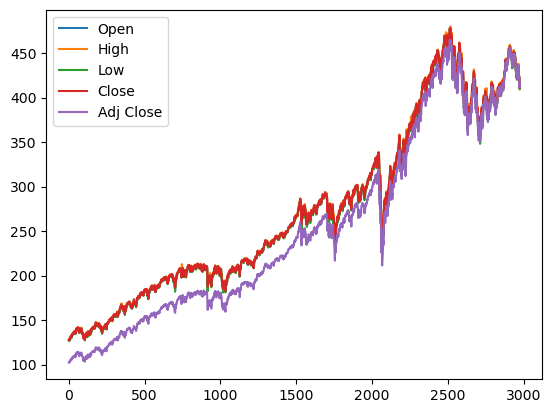

In [9]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()


In [29]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
"""
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df_for_training)
"""
df_for_training_scaled = scaler.transform(df_for_training)
print(df_for_training_scaled)

[[-1.48905332 -1.4876545  -1.48726868 -1.49223964 -1.42848182]
 [-1.49480127 -1.49346493 -1.49471571 -1.49018674 -1.4269465 ]
 [-1.4967514  -1.48918363 -1.49761176 -1.48669678 -1.42433624]
 ...
 [ 1.47409434  1.45778791  1.45192604  1.43371205  1.53430682]
 [ 1.45089734  1.42995955  1.42720591  1.41451712  1.51643981]
 [ 1.4444309   1.45116212  1.4583387   1.46491681  1.56335281]]


In [31]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [32]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

trainX shape == (2962, 14, 5).
trainY shape == (2962, 1).


In [53]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 128)           68608     
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 118081 (461.25 KB)
Trainable params: 118081 (461.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
# fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/30
167/167 [==============================] - 6s 17ms/step - loss: 0.0630 - val_loss: 0.0957
Epoch 2/30
167/167 [==============================] - 2s 13ms/step - loss: 0.0232 - val_loss: 0.0071
Epoch 3/30
167/167 [==============================] - 2s 12ms/step - loss: 0.0193 - val_loss: 0.0190
Epoch 4/30
167/167 [==============================] - 2s 14ms/step - loss: 0.0184 - val_loss: 0.0061
Epoch 5/30
167/167 [==============================] - 3s 16ms/step - loss: 0.0187 - val_loss: 0.0238
Epoch 6/30
167/167 [==============================] - 2s 14ms/step - loss: 0.0181 - val_loss: 0.0082
Epoch 7/30
167/167 [==============================] - 2s 14ms/step - loss: 0.0166 - val_loss: 0.0030
Epoch 8/30
167/167 [==============================] - 2s 14ms/step - loss: 0.0171 - val_loss: 0.0109
Epoch 9/30
167/167 [==============================] - 2s 13ms/step - loss: 0.0179 - val_loss: 0.0049
Epoch 10/30
167/167 [==============================] - 2s 14ms/step - loss: 0.0170 - val_lo

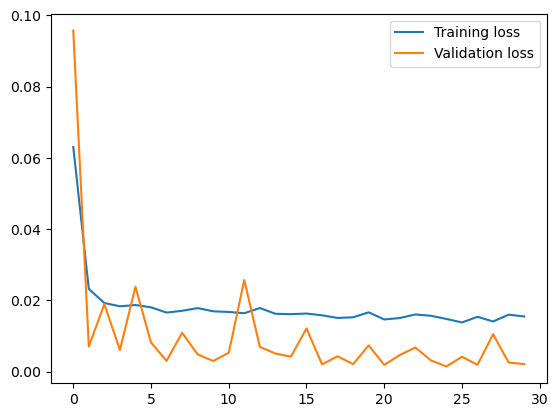

In [55]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [56]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [57]:
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 400
n_days_for_prediction=399  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-03-29 00:00:00', freq='C'), Timestamp('2022-03-30 00:00:00', freq='C'), Timestamp('2022-03-31 00:00:00', freq='C'), Timestamp('2022-04-01 00:00:00', freq='C'), Timestamp('2022-04-04 00:00:00', freq='C'), Timestamp('2022-04-05 00:00:00', freq='C'), Timestamp('2022-04-06 00:00:00', freq='C'), Timestamp('2022-04-07 00:00:00', freq='C'), Timestamp('2022-04-08 00:00:00', freq='C'), Timestamp('2022-04-11 00:00:00', freq='C'), Timestamp('2022-04-12 00:00:00', freq='C'), Timestamp('2022-04-13 00:00:00', freq='C'), Timestamp('2022-04-14 00:00:00', freq='C'), Timestamp('2022-04-15 00:00:00', freq='C'), Timestamp('2022-04-18 00:00:00', freq='C'), Timestamp('2022-04-19 00:00:00', freq='C'), Timestamp('2022-04-20 00:00:00', freq='C'), Timestamp('2022-04-21 00:00:00', freq='C'), Timestamp('2022-04-22 00:00:00', freq='C'), Timestamp('2022-04-25 00:00:00', freq='C'), Timestamp('2022-04-26 00:00:00', freq='C'), Timestamp('2022-04-27 00:00:00', freq='C'), Timestamp('2022-04-28 00:00:00'

In [58]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

13/13 [==============================] - 0s 8ms/step


In [59]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [60]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [61]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-5-1']

/var/folders/tt/rynv9sfx6hd7zsm3w8y6qv8c0000gn/T/ipykernel_87660/3499364583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


/Users/soka_1215/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/soka_1215/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Open'>

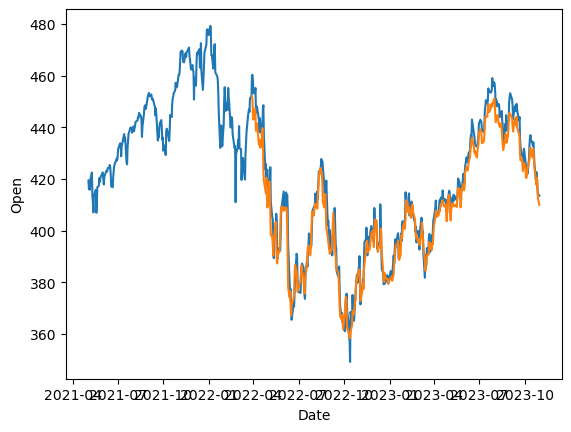

In [62]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])